<a href="https://colab.research.google.com/github/Palakds/python-files/blob/main/Instacart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd

# Load datasets
orders = pd.read_csv('orders.csv')
order_products_prior = pd.read_csv('order_products__prior.csv')
order_products_train = pd.read_csv('order_products__train.csv')
products = pd.read_csv('products.csv')
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')

In [4]:
from pyspark.sql import SparkSession

# Initialize Spark Session
spark = SparkSession.builder.appName("InstacartEDA").getOrCreate()


In [5]:
# Load CSV files into PySpark DataFrames
orders_df = spark.read.csv("orders.csv", header=True, inferSchema=True)
order_products_df = spark.read.csv("order_products__prior.csv", header=True, inferSchema=True)
products_df = spark.read.csv("products.csv", header=True, inferSchema=True)
aisles_df = spark.read.csv("aisles.csv", header=True, inferSchema=True)
departments_df = spark.read.csv("departments.csv", header=True, inferSchema=True)


In [6]:
orders_df.printSchema()
order_products_df.printSchema()
products_df.printSchema()
aisles_df.printSchema()
departments_df.printSchema()


root
 |-- order_id: integer (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- eval_set: string (nullable = true)
 |-- order_number: integer (nullable = true)
 |-- order_dow: integer (nullable = true)
 |-- order_hour_of_day: integer (nullable = true)
 |-- days_since_prior_order: double (nullable = true)

root
 |-- order_id: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- add_to_cart_order: integer (nullable = true)
 |-- reordered: integer (nullable = true)

root
 |-- product_id: integer (nullable = true)
 |-- product_name: string (nullable = true)
 |-- aisle_id: string (nullable = true)
 |-- department_id: string (nullable = true)

root
 |-- aisle_id: integer (nullable = true)
 |-- aisle: string (nullable = true)

root
 |-- department_id: integer (nullable = true)
 |-- department: string (nullable = true)



In [7]:
# Show first 5 rows
orders_df.show(5)
order_products_df.show(5)
products_df.show(5)
aisles_df.show(5)
departments_df.show(5)


+--------+-------+--------+------------+---------+-----------------+----------------------+
|order_id|user_id|eval_set|order_number|order_dow|order_hour_of_day|days_since_prior_order|
+--------+-------+--------+------------+---------+-----------------+----------------------+
| 2539329|      1|   prior|           1|        2|                8|                  NULL|
| 2398795|      1|   prior|           2|        3|                7|                  15.0|
|  473747|      1|   prior|           3|        3|               12|                  21.0|
| 2254736|      1|   prior|           4|        4|                7|                  29.0|
|  431534|      1|   prior|           5|        4|               15|                  28.0|
+--------+-------+--------+------------+---------+-----------------+----------------------+
only showing top 5 rows

+--------+----------+-----------------+---------+
|order_id|product_id|add_to_cart_order|reordered|
+--------+----------+-----------------+--------

In [8]:
from pyspark.sql.functions import col, sum

# Function to check missing values in a DataFrame
def check_missing_values(df):
    return df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

# Check missing values
check_missing_values(orders_df)
check_missing_values(order_products_df)
check_missing_values(products_df)


+--------+-------+--------+------------+---------+-----------------+----------------------+
|order_id|user_id|eval_set|order_number|order_dow|order_hour_of_day|days_since_prior_order|
+--------+-------+--------+------------+---------+-----------------+----------------------+
|       0|      0|       0|           0|        0|                0|                 20582|
+--------+-------+--------+------------+---------+-----------------+----------------------+

+--------+----------+-----------------+---------+
|order_id|product_id|add_to_cart_order|reordered|
+--------+----------+-----------------+---------+
|       0|         0|                0|        0|
+--------+----------+-----------------+---------+

+----------+------------+--------+-------------+
|product_id|product_name|aisle_id|department_id|
+----------+------------+--------+-------------+
|         0|           0|       0|            0|
+----------+------------+--------+-------------+



In [9]:
products_df.select("product_id").distinct().count()


49688

In [10]:
from pyspark.sql.functions import desc

order_products_df.groupBy("product_id").count().orderBy(desc("count")).show(10)


+----------+-----+
|product_id|count|
+----------+-----+
|     24852|11625|
|     13176| 9371|
|     21137| 6443|
|     21903| 5895|
|     47209| 5237|
|     47766| 4250|
|     47626| 3715|
|     16797| 3444|
|     26209| 3388|
|     27966| 3335|
+----------+-----+
only showing top 10 rows



In [11]:
orders_df.groupBy("order_hour_of_day").count().orderBy("order_hour_of_day").show()


+-----------------+-----+
|order_hour_of_day|count|
+-----------------+-----+
|                0| 2085|
|                1| 1190|
|                2|  699|
|                3|  527|
|                4|  584|
|                5|  963|
|                6| 3027|
|                7| 9211|
|                8|17759|
|                9|25458|
|               10|28358|
|               11|28248|
|               12|27523|
|               13|27769|
|               14|27923|
|               15|28188|
|               16|27148|
|               17|22946|
|               18|18277|
|               19|14051|
+-----------------+-----+
only showing top 20 rows



In [12]:
orders_df.selectExpr("avg(days_since_prior_order) as avg_days_between_orders").show()


+-----------------------+
|avg_days_between_orders|
+-----------------------+
|      11.11648031570046|
+-----------------------+



In [13]:
order_products_df.join(products_df, "product_id") \
    .join(aisles_df, "aisle_id") \
    .groupBy("aisle").count().orderBy(desc("count")).show(10)


+--------------------+-----+
|               aisle|count|
+--------------------+-----+
|        fresh fruits|88652|
|    fresh vegetables|82596|
|packaged vegetabl...|42913|
|              yogurt|35247|
|     packaged cheese|23711|
|                milk|21639|
|water seltzer spa...|20181|
|      chips pretzels|17441|
|     soy lactosefree|15724|
|               bread|14303|
+--------------------+-----+
only showing top 10 rows



In [14]:
orders_df.groupBy("user_id").count().orderBy(desc("count")).show(10)


+-------+-----+
|user_id|count|
+-------+-----+
|   8664|  100|
|  10502|  100|
|   3377|  100|
|   8086|  100|
|   2387|  100|
|   8085|  100|
|   2231|  100|
|  10293|  100|
|   7120|  100|
|  14437|  100|
+-------+-----+
only showing top 10 rows



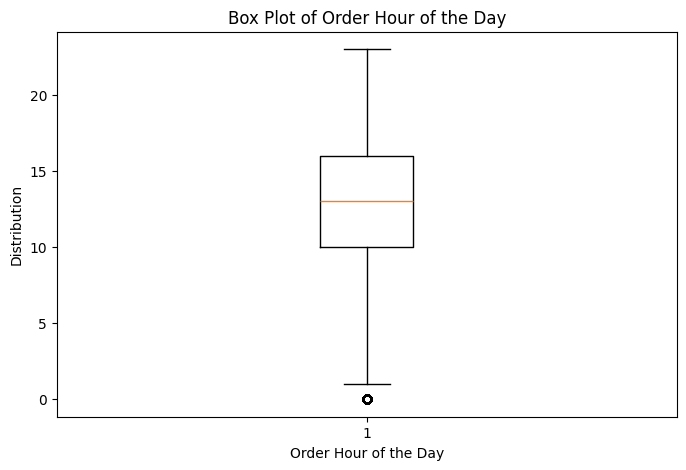

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas
pdf = orders_df.select("order_hour_of_day").toPandas()

# Box Plot for Order Time Distribution
plt.figure(figsize=(8, 5))
plt.boxplot(pdf["order_hour_of_day"])
plt.xlabel("Order Hour of the Day")
plt.ylabel("Distribution")
plt.title("Box Plot of Order Hour of the Day")
plt.show()


In [16]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, expr
from pyspark.ml.fpm import FPGrowth
from pyspark.ml.recommendation import ALS


In [17]:
# Load dataset
order_products_df = spark.read.csv("order_products__prior.csv", header=True, inferSchema=True)

# Group transactions by order_id to get product lists
basket_df = order_products_df.groupBy("order_id") \
    .agg(expr("collect_list(product_id) as items"))

basket_df.show(5, truncate=False)


+--------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|order_id|items                                                                                                                                                                             |
+--------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|3       |[33754, 24838, 17704, 21903, 17668, 46667, 17461, 32665]                                                                                                                          |
|5       |[13176, 15005, 47329, 27966, 23909, 48370, 13245, 9633, 27360, 6348, 40878, 6184, 48002, 20914, 37011, 12962, 45698, 24773, 18569, 41176, 48366, 47209, 46522, 38693, 48825, 8479]|
|6       |[40462, 15873, 41897]                   

In [18]:
# Apply FPGrowth Model
fp_growth = FPGrowth(itemsCol="items", minSupport=0.01, minConfidence=0.3)
model = fp_growth.fit(basket_df)

# Display Frequent Itemsets (Most Commonly Bought Together Products)
model.freqItemsets.show(10, truncate=False)

# Display Association Rules (If you buy X, then Y is also bought)
model.associationRules.show(10, truncate=False)


+-------+----+
|items  |freq|
+-------+----+
|[34358]|1357|
|[19678]|1214|
|[4799] |1394|
|[19660]|2086|
|[27521]|1618|
|[27104]|2674|
|[5450] |1825|
|[9076] |2196|
|[26209]|5296|
|[19057]|2825|
+-------+----+
only showing top 10 rows

+----------+----------+-------------------+------------------+--------------------+
|antecedent|consequent|confidence         |lift              |support             |
+----------+----------+-------------------+------------------+--------------------+
|[27966]   |[13176]   |0.3004484304932735 |2.512623151568024 |0.012693993212296946|
|[47766]   |[24852]   |0.30438784903344585|2.0604141474999547|0.01634320735444331 |
|[28204]   |[24852]   |0.37849079025549615|2.5620200721454336|0.010494579722560874|
+----------+----------+-------------------+------------------+--------------------+



In [19]:
# Load order data
orders_df = spark.read.csv("orders.csv", header=True, inferSchema=True)

# Merge order and product data to create user-item interactions
user_item_df = order_products_df.join(orders_df, "order_id") \
    .select("user_id", "product_id")

# Assign implicit ratings (Count how often each user orders a product)
user_ratings_df = user_item_df.groupBy("user_id", "product_id") \
    .agg(count("*").alias("rating"))

user_ratings_df.show(5)


+-------+----------+------+
|user_id|product_id|rating|
+-------+----------+------+
|  22352|     15873|     1|
|   5430|     15424|     1|
|  40286|     23001|     1|
|   4076|     47049|     2|
|  46527|     24497|     1|
+-------+----------+------+
only showing top 5 rows



In [20]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, expr
from pyspark.ml.fpm import FPGrowth
from pyspark.ml.recommendation import ALS

# Load order data
orders_df = spark.read.csv("orders.csv", header=True, inferSchema=True)

# Load dataset
order_products_df = spark.read.csv("order_products__prior.csv", header=True, inferSchema=True)

# Merge order and product data to create user-item interactions
user_item_df = order_products_df.join(orders_df, "order_id") \
    .select("user_id", "product_id")

# Filter out rows with null product_id before grouping and calculating ratings
user_item_df = user_item_df.filter(col("product_id").isNotNull())

# Assign implicit ratings (Count how often each user orders a product)
user_ratings_df = user_item_df.groupBy("user_id", "product_id") \
    .agg(count("*").alias("rating"))

user_ratings_df.show(5)

als = ALS(userCol="user_id", itemCol="product_id", ratingCol="rating",
          coldStartStrategy="drop", implicitPrefs=True)

als_model = als.fit(user_ratings_df)

+-------+----------+------+
|user_id|product_id|rating|
+-------+----------+------+
|  22352|     15873|     1|
|   5430|     15424|     3|
|  40286|     23001|     1|
|   4076|     47049|     2|
|  46527|     24497|     1|
+-------+----------+------+
only showing top 5 rows



In [21]:
# Generate top 5 product recommendations for each user
user_recommendations = als_model.recommendForAllUsers(5)
user_recommendations.show(5, truncate=False)


+-------+--------------------------------------------------------------------------------------------------------+
|user_id|recommendations                                                                                         |
+-------+--------------------------------------------------------------------------------------------------------+
|5      |[{16797, 0.23159084}, {4920, 0.16453604}, {40706, 0.14115907}, {27104, 0.13465239}, {45007, 0.13290131}]|
|12     |[{13176, 0.57299584}, {21903, 0.43911177}, {49683, 0.32069173}, {42265, 0.2649871}, {30489, 0.25586066}]|
|13     |[{27086, 0.15644014}, {28204, 0.13849887}, {16797, 0.096922845}, {5785, 0.08753907}, {5876, 0.07721993}]|
|15     |[{6184, 0.12421208}, {196, 0.12331775}, {12341, 0.10630153}, {43352, 0.09162545}, {16797, 0.07539251}]  |
|19     |[{16797, 0.16479175}, {9076, 0.15122052}, {23909, 0.14855023}, {5077, 0.13489091}, {29487, 0.11024181}] |
+-------+-----------------------------------------------------------------------

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert frequent itemsets from FP-Growth to Pandas
fp_growth_pd = model.freqItemsets.toPandas()

# Convert association rules from FP-Growth to Pandas
association_rules_pd = model.associationRules.toPandas()

# Convert ALS recommendations to Pandas
user_recommendations_pd = user_recommendations.toPandas()


<Figure size 1200x600 with 0 Axes>

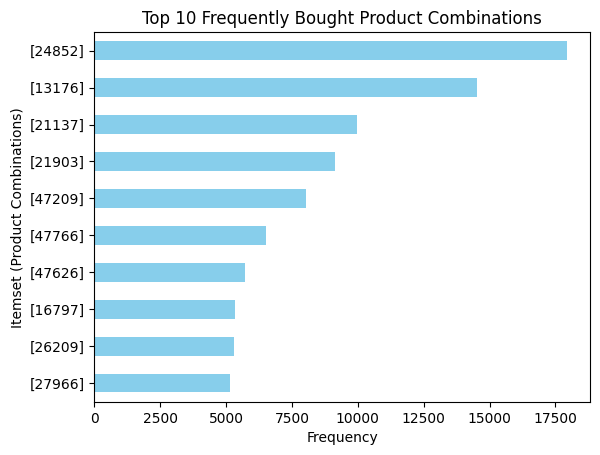

In [23]:
plt.figure(figsize=(12, 6))
fp_growth_pd.sort_values(by="freq", ascending=False).head(10).plot(
    kind="barh", x="items", y="freq", legend=False, color="skyblue"
)

plt.xlabel("Frequency")
plt.ylabel("Itemset (Product Combinations)")
plt.title("Top 10 Frequently Bought Product Combinations")
plt.gca().invert_yaxis()
plt.show()


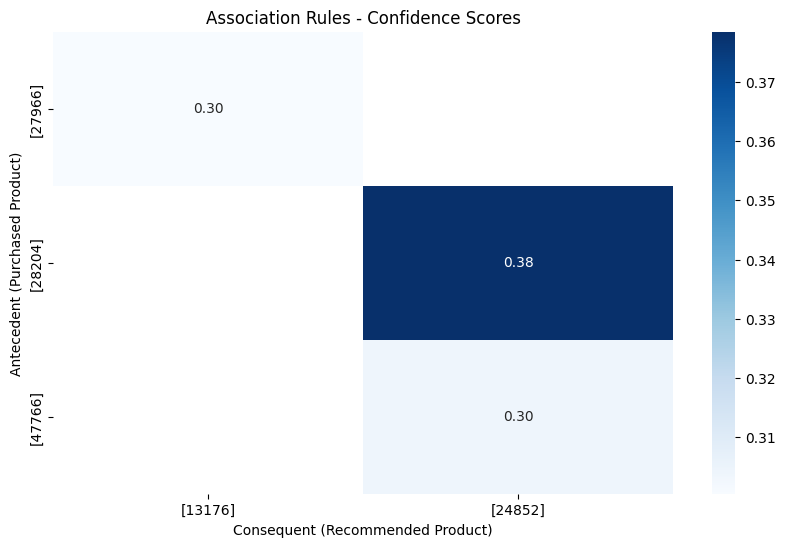

In [24]:
plt.figure(figsize=(10, 6))

# Ensure the 'antecedent' and 'consequent' columns are in string format
association_rules_pd["antecedent"] = association_rules_pd["antecedent"].astype(str)
association_rules_pd["consequent"] = association_rules_pd["consequent"].astype(str)

# Reshape the data correctly using pivot_table
pivot_table = association_rules_pd.pivot_table(index="antecedent", columns="consequent", values="confidence")

# Plot heatmap
sns.heatmap(pivot_table, cmap="Blues", annot=True, fmt=".2f")

plt.xlabel("Consequent (Recommended Product)")
plt.ylabel("Antecedent (Purchased Product)")
plt.title("Association Rules - Confidence Scores")
plt.show()


<ipython-input-25-b1ec6fcce12b>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=recommended_products, y=range(len(recommended_products)), palette="viridis")


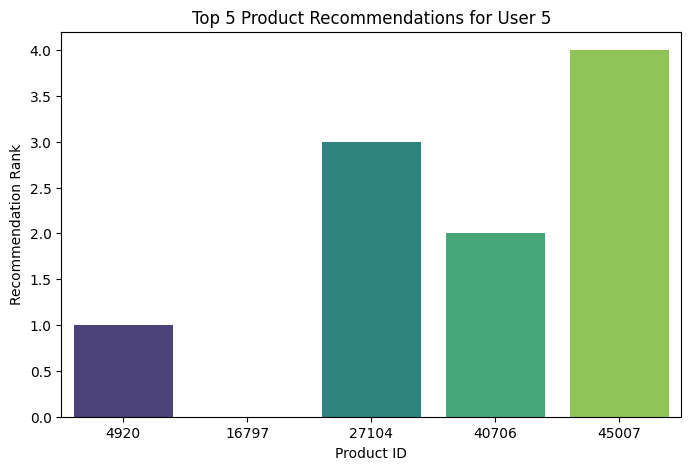

In [25]:
# Extract a sample user’s recommendations
sample_user = user_recommendations_pd.iloc[0]
user_id = sample_user["user_id"]
recommended_products = [row.product_id for row in sample_user["recommendations"]]

# Plot Recommended Products for a Sample User
plt.figure(figsize=(8, 5))
sns.barplot(x=recommended_products, y=range(len(recommended_products)), palette="viridis")
plt.xlabel("Product ID")
plt.ylabel("Recommendation Rank")
plt.title(f"Top 5 Product Recommendations for User {user_id}")
plt.show()
